In [1]:
# Data Science Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

# Model Specific Libraries
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import PolynomialFeatures

# Blocking Warning Boxes
import warnings
warnings.filterwarnings("ignore")

# Import group-made Zillow Funtions Module 
import wrangle


![Image of Zillow Logo](https://www.roundtablerealty.com/uploads/agent-1/699119.png)

<div align="center">
    

### By Joann Balraj & Jeanette Schulz 
### January 10, 2022

# Zillow: What is driving the errors in the Zestimates? 

</div align="center">
    

<hr style="border:2px solid blue"> </hr>

# Project Goal
For this project, we will look into finding drivers of error in the Zestimate. Using clustering methodologies, feature identification and comparison, visualizations, statistical testing, and regression models, we are to find drivers of error to predict log error. Zillows existing Zestimate model is pretty good but not perfect, which means modeling errors can be a very powerful way to find areas to improve that existing model. The goal of this project is to create a model to predict these Zestimate errors, and deliver our findings in a video presentation. 


<hr style="border:2px solid blue"> </hr>


# Executive Summary
The Linear Regression Model was our best model, which performed better than Baseline by having the lowest RMSE and a 𝑅2 of 0.000402. However, even though it performed better than the rest of the models, it still does not seem to be a significant predictor of error.


<hr style="border:2px solid blue"> </hr>

# Aquire

In [2]:
# Aquiring the data with function from wrangle.py
df = wrangle.get_zillow_data()
df = df.dropna()
df.head()

bedrooms  bathrooms  squarefeet  year_built  regionidzip    fips  \
0       4.0        3.5      3100.0      1998.0      96978.0  6059.0   
1       2.0        1.0      1465.0      1967.0      97099.0  6111.0   
2       3.0        2.0      1243.0      1962.0      97078.0  6059.0   
3       4.0        3.0      2376.0      1970.0      96330.0  6037.0   
4       4.0        3.0      2962.0      1950.0      96293.0  6037.0   

   tax_value  logerror transactiondate    longitude    latitude  
0  1023282.0  0.025595      2017-01-01 -117869207.0  33634931.0  
1   464000.0  0.055619      2017-01-01 -119281531.0  34449266.0  
2   564778.0  0.005383      2017-01-01 -117823170.0  33886168.0  
3   145143.0 -0.103410      2017-01-01 -118240722.0  34245180.0  
4   773303.0 -0.001011      2017-01-01 -118179824.0  34145202.0

<hr style="border:2px solid blue"> </hr>

# Prepare
The data was prepared by functions created in the wrangle.py module that prepares the data by: Dropping all rows with NULL values, Dropping all rows that had any value as Zero, changing the datatypes of some columns, removing outliers, feature engineering, and seperating the data into train, test, validate for modeling and exploration of the data.



<hr style="border:2px solid blue"> </hr>

<img src="Images/explore.gif" alt="Exploring Features" title="Exploring Features" width="300" height="100" align="right">

# Explore
The target variable will be logerror. Since we do not know the Zestimate of the home, nor the price it truely sold for, we only have the logerror as a reference for Zestimate error. So that is what we will explore.

In [3]:
# Define our alpha for 95% confidence
alpha = 0.05

In [4]:
# Splitting our Data so we only explore on "train"
train, validate, test = wrangle.wrangle_zillow()

# Scaling data
train, validate, test = wrangle.Min_Max_Scaler(train, validate, test)

# Checking our dataframes
train.shape, validate.shape, test.shape

((25529, 12), (10942, 12), (9118, 12))


## Question 1: Does square footage affect Zestimate log error?

### Hypothesis :
$Ho$ : There is no correlation between square footage and log error

$Ha$ : Square footage and log error are correlated

# why do you drop nulls?

In [5]:
train = train.dropna()
test = test.dropna()
validate = validate.dropna()

x = train.squarefeet
y = train.logerror

corr, p = stats.pearsonr(x, y)
corr, p

if p < alpha:
    print("We reject the null hypothesis")

else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


#### Null hypothesis is rejected.  Square footage and log error are correlated.


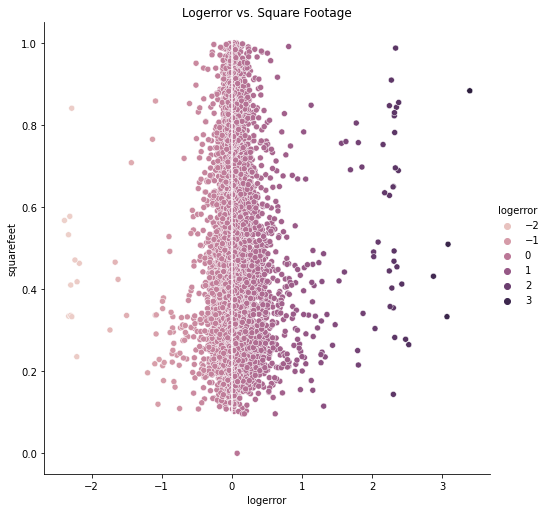

In [6]:
# Let's look at this visually 
sns.relplot(data=train, x="logerror", y="squarefeet", hue='logerror', height=7, aspect=1).set(title="Logerror vs. Square Footage");
plt.axvline(0, color='white');


## Question 2: Does county affect Zestimate log error?

### Levene's Test: test for equal variance
$Ho$: There is no difference in logerror variance between the counties

$Ha$: There is a difference in logerror variance between the counties

In [7]:
train['county'] = train['fips']

print(stats.levene(
    train[train.county == 6037.0].logerror,
    train[train.county != 6037.0].logerror,
))
print(stats.levene(
    train[train.county == 6059.0].logerror,
    train[train.county != 6059.0].logerror,
))
print(stats.levene(
    train[train.county == 6111.0].logerror,
    train[train.county != 6111.0].logerror,
))

LeveneResult(statistic=30.01233549473158, pvalue=4.333586430633437e-08)
LeveneResult(statistic=10.959310962964059, pvalue=0.0009326352705803517)
LeveneResult(statistic=17.381368082449242, pvalue=3.06817209619698e-05)


#### We reject the null hypothesis that the variance in logerror is the same for all counties. The variance is not equal.

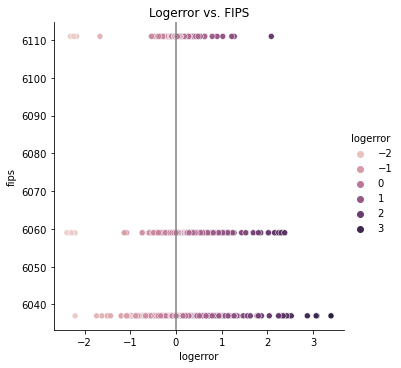

In [8]:
# Let's take a look visually
sns.relplot(data=train, x='logerror', y='fips', hue = 'logerror').set(title="Logerror vs. FIPS");
plt.axvline(0, color='grey');

## Question 3: If we control for month, does log error differ across county?
1. Viz logerror by county for each month bin


2. Analyze each month bin separately

In [32]:
train['transactiondate'] = pd.to_datetime(train['transactiondate'])
train['month'] = pd.DatetimeIndex(train['transactiondate']).month

# binning transactiondate for comparison and visualization purposes
train['Months'] = pd.cut(train.month, [0,3,6,9])

train['county'] = train['fips'].apply(
        lambda x: 'Los Angeles' if x == 6037\
        else 'Orange' if x == 6059\
        else 'Ventura')

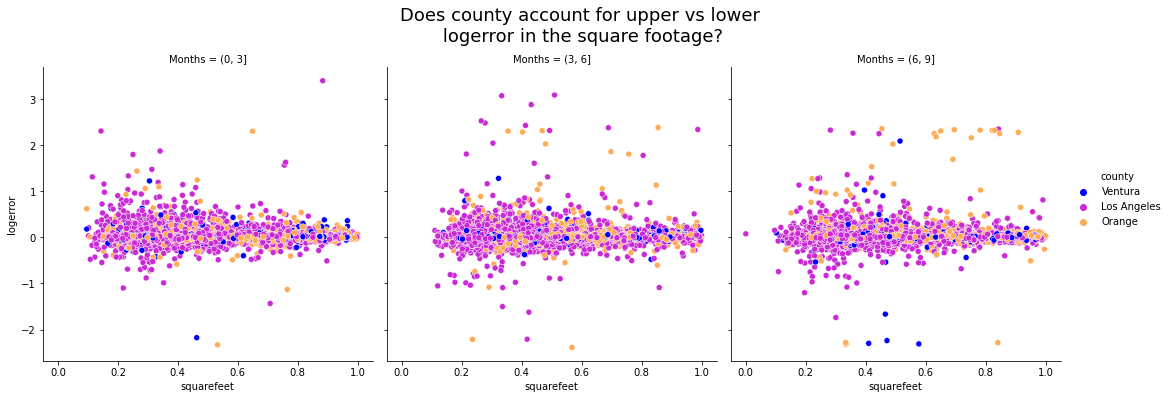

In [33]:
sns.relplot(x='squarefeet',y='logerror',data=train, hue='county',col='Months', height=5, palette='gnuplot2')
plt.suptitle("Does county account for upper vs lower\n logerror in the square footage?", y=1.1, size=18);

 For sales before July 1st, log error may be grouped by county where Orange County and LA County have higher errors.

 Logerror does not seem to vary much by month or county

Orange County seems to have higher log errors compared to the other counties, 
especially during the months of June-Sept.  Los Angeles county seems to have more variance in error, being more 
scattered on both sides of 0.

Comparing using tax value, Orange County still seems to have the highest log errors, especially during June-Sept

Comparing using tax value, Orange County accounts for most of the upper band seen in the log error 
(higher lognerror) especially for homes between 2,000-3,000 square feet.
Overall, county does seem to be grouped together for certain months and certain square footage

_____

## Question 4: Does log error differ for different number of bedrooms?

### Levene's Test: test for equal variance
$Ho$: There is no difference in logerror variance for different number of bedrooms

$Ha$: There is a difference in logerror variance different number of bedrooms

In [11]:
stats.levene(
    train[train.bedrooms <= 4].logerror,
    train[train.bedrooms > 4].logerror,
)

LeveneResult(statistic=4.195211649779681, pvalue=0.04054849950098029)

We fail to reject the null hypothesis that there is no difference in logerror variance for different number of bedrooms.
The variance is equal.

### Is the log error the same for properties with 4 or less as those with more than 4 bedrooms?
$Ho$: The logerror is the same for properties with 4 bedrooms or less as with those with more than 4 bedrooms

$Ha$: The logerror is not the same for properties with 4 bedrooms or less as with those with 5 bedrooms

In [12]:
stats.ttest_ind(
   train[train.bedrooms <= 4].logerror,
    train[train.bedrooms > 4].logerror,
    equal_var=True,
)

Ttest_indResult(statistic=-3.266964236906971, pvalue=0.0010885087985330435)

### Conclusion:
We reject the null hypothesis that the log error is the same for properties with 4 bedrooms or less compared to those with 5 bedrooms. The log error is not the same for properties with 4 bedrooms or less compared to those with 5 bedrooms.

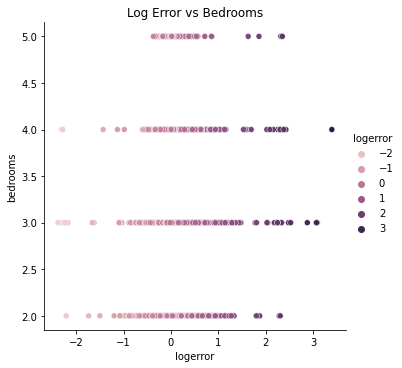

In [13]:
sns.relplot(y='bedrooms',x='logerror',data=train,hue='logerror')
plt.title("Log Error vs Bedrooms");

### Hypothesis:
$Ho$: There is no correlation between number of bedrooms and log error

$Ha$: Number of bedrooms and log error are correlated

In [14]:
x = train.bedrooms
y = train.logerror


corr, p = stats.pearsonr(x, y)
corr, p

(0.03228514619664852, 2.4754745517146133e-07)

#### Null hypothesis is rejected.  Number of bedrooms and log error are correlated.
_____________

## Exploring with Clustering
#### Use Clustering to Identify Possible Features of Interest
 - We do not any features indicating location near the coast, so we will look at latitude and longitude features to see if we can create a possible feature of interest for modeling and predicting

## Clustering Model # 1:

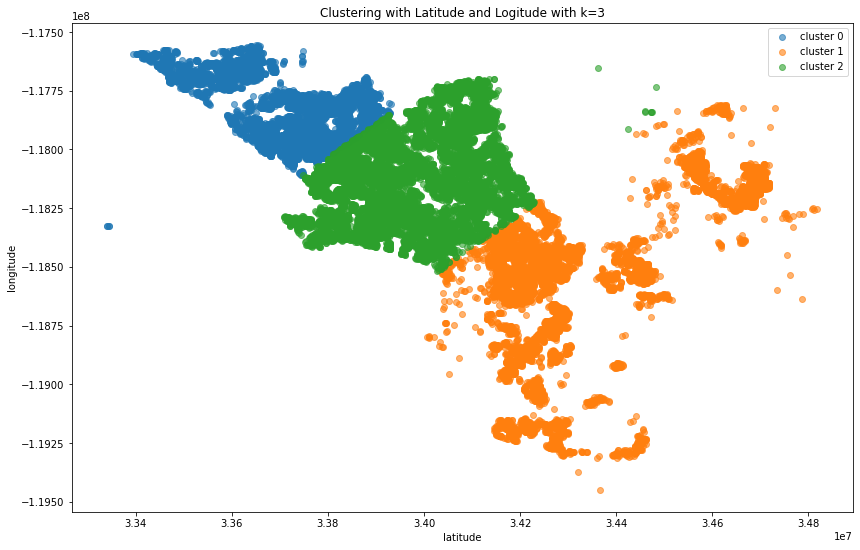

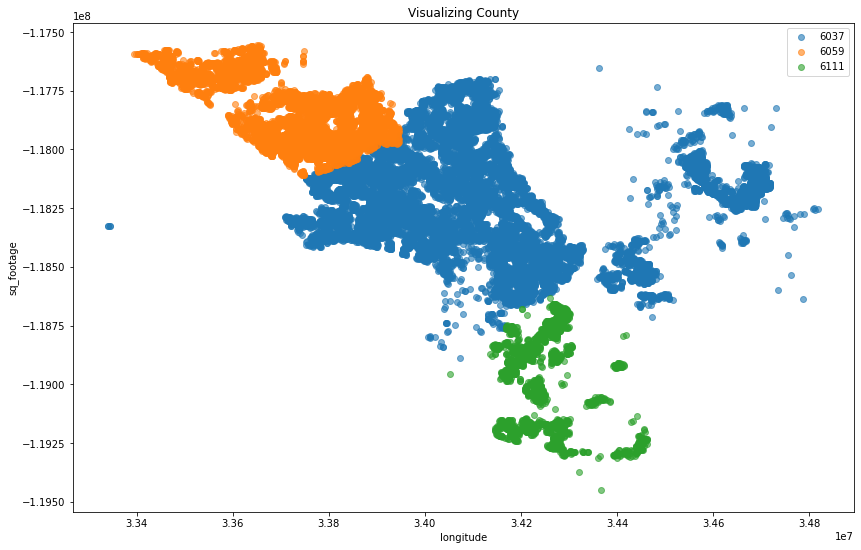

In [15]:
# Choose two features to create possible cluster
# Define independent variables for k-means
X = train[['latitude', 'longitude']]
scaler = MinMaxScaler().fit(X)
X_scaled_lat_long = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

# Define the thing and create 3 clusters
kmeans = KMeans(n_clusters=3, random_state=321)

# Fit the thing
kmeans.fit(X_scaled_lat_long )

# Use (predict using) the thing 
kmeans.predict(X_scaled_lat_long )
train['cluster'] = kmeans.predict(X_scaled_lat_long )

X_scaled_lat_long['cluster'] = kmeans.predict(X_scaled_lat_long )

# Saving this clustering for use in independence testing and possible modeling
train['cluster_lat_long'] = train['cluster']

# Visualizing the clusters by plotting them 
plt.figure(figsize=(14, 9))

for cluster, subset in train.groupby('cluster'):
    plt.scatter(subset.latitude, subset.longitude, label='cluster ' + str(cluster), alpha=.6, cmap='reds')
plt.legend()
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title("Clustering with Latitude and Logitude with k=3")
plt.show()

# compare against the actual data by county to compare how the clustering did
plt.figure(figsize=(14, 9))
for cluster, subset in train.groupby('fips'):
    plt.scatter(subset.latitude, subset.longitude, label=str(cluster), alpha=.6)

plt.legend()
plt.xlabel('longitude')
plt.ylabel('sq_footage')
plt.title('Visualizing County')
plt.show();

______

## Clustering Model # 2:

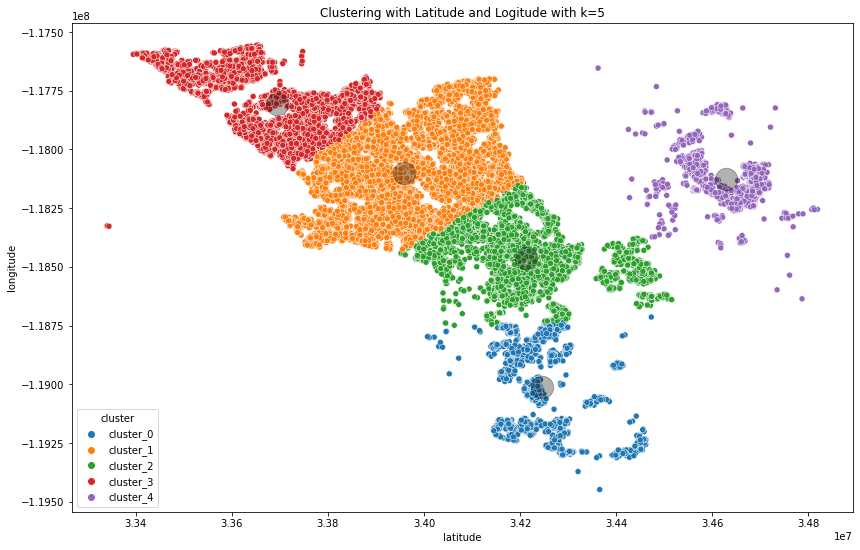

In [16]:
# We will create more clusters on the same features using a different k for grouping
X = train[['latitude', 'longitude']]

# use the create cluster function from wrangle.py with k value from inertia plot
train, X_scaled_lat_long_k5, scaler, kmeans, centroids = wrangle.create_cluster(train, X, 5)

# save this clustering for use in independence testing and possible modeling
train['cluster_lat_long_k5'] = [x.strip()[-1] for x in train['cluster']]
train['cluster_lat_long_k5'] = pd.to_numeric(train['cluster_lat_long_k5'],errors='coerce')

# use the create_scatter_plot function from wrangle.py to plot the data
wrangle.create_scatter_plot('latitude', 'longitude',train,kmeans, X_scaled_lat_long_k5, scaler)
plt.title("Clustering with Latitude and Logitude with k=5");

 Even though we only have 3 counties, the grouping by cluster looks good in this model and may be 
 helpful for predicting log error.

______

## Clustering Model # 3:
#### Repeat the clustering, this time with 3 different features.

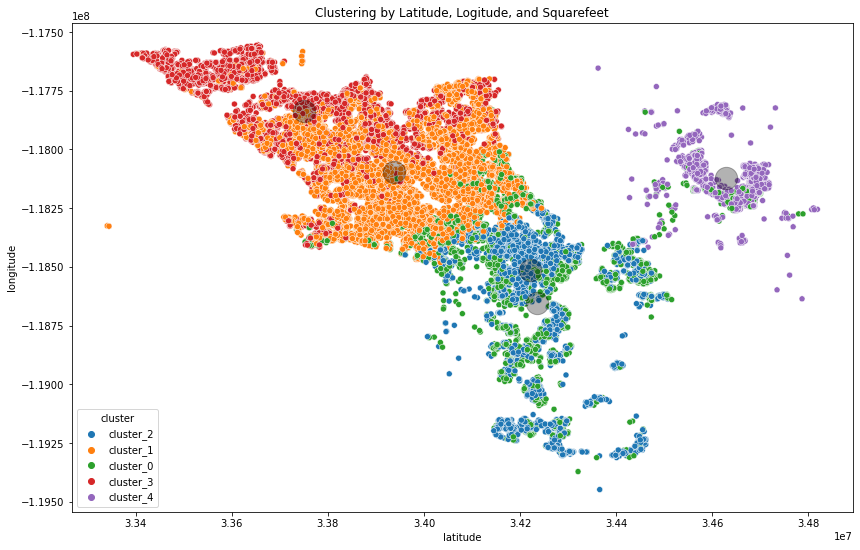

In [17]:
# we will create cluster on three features
X = train[['latitude','longitude','squarefeet']]

# use the create cluster function from wrangle.py with k value from inertia plot
train, X_scaled_lat_long_sqft, scaler, kmeans, centroids = wrangle.create_cluster(train, X, 5)

# save this clustering for use in independence testing and possible modeling
train['cluster_lat_long_sqft'] = [x.strip()[-1] for x in train['cluster']]
train['cluster_lat_long_sqft'] = pd.to_numeric(train['cluster_lat_long_sqft'],errors='coerce')

# use the create_scatter_plot function from wrangle.py to plot the cluster data
wrangle.create_scatter_plot('latitude', 'longitude', train, kmeans, X_scaled_lat_long_sqft, scaler)
plt.title("Clustering by Latitude, Logitude, and Squarefeet");

Since we're using 3 features for clustering, the clusters could be mapping to three dimensions and 
thus why some are overlapping throughout.

After exploring using clustering, we try **statistical tests** to check if latitude and longitude are correlated to log error:
### Hypotheses:
$Ho$: There is no correlation between latitude and log error

$Ha$: Latitude and log error are correlated

In [18]:
x = train.latitude
y = train.logerror

corr, p = stats.pearsonr(x, y)
corr, p

(-0.02099110513119053, 0.000796173981469638)

#### Null hypothesis is rejected.  Latitude and log error are correlated.

### Hypotheses:
$Ho$: There is no correlation between longitude and log error

$Ha$: Longitude and log error are correlated

In [19]:
x = train.longitude
y = train.logerror

corr, p = stats.pearsonr(x, y)
corr, p

(0.023193783106614053, 0.0002104148809666757)

 Null hypothesis is rejected.  Longitude and log error are correlated.
Latitude and longitude are both correlated to log error and can be used for predictors of error in the model.



## Statistical Tests for Independence on Clusters
#### To compare if each cluster is independent of log error, we need to compare the overall log error mean to the mean of each cluster region to see if there is a signifant difference.
 - We need to compare the mean of the log error of each one compared to the mean of the log error of all clusters
 
_______


## Cluster # 1 - Latitude and Longitude:

In [20]:
# calculating overall log error mean to use for hypothesis testing
logerror_mean =  train.logerror.mean()

logerror_mean

0.016410461659818368

In [21]:
# looping through all the regions in the cluster to calculate it's mean and compare it
# to the overall log error mean to see if it may be of significance

count = train.cluster_lat_long.max()
i = 0
while i <= count:
        region_mean = train[train.cluster_lat_long == i].logerror.mean()
        difference = abs(logerror_mean - region_mean)
        region_mean_df = pd.DataFrame(data=[
            {
                'region': i,
                'mean':region_mean,
                'difference': difference
            }
            ])
        region_mean_df.append(
            {
                'region': i,
                'mean':region_mean,
                'difference': difference
            },
            ignore_index=True)
        print(region_mean_df)    
        i += 1

   region      mean  difference
0       0  0.024148    0.007738
   region      mean  difference
0       1  0.015308    0.001103
   region      mean  difference
0       2  0.013317    0.003093


In [22]:
# creating a column with the log error values of cluster 0 since it had the biggest difference to run
# a statistical test  

clust_1_0 = train[train.cluster_lat_long == 0].logerror

> ### Clustering Hypotheses # 1:


$Ho$: There is no relationship between logerror and cluster # 1 region # 3 

$Ha$: There is a relationship between logerror and cluster # 1 region # 3

In [23]:
stats.ttest_ind(train.logerror, clust_1_0)

Ttest_indResult(statistic=-3.227860521362777, pvalue=0.0012484812079437675)

#### We rejected the null hypothesis. Cluster # 1 Region # 0 could be used to predict log error.

___

## Cluster # 2 - Latitude and Longitude with 5 clusters (k = 5)

In [24]:
# looping through all the regions in the cluster to calculate it's mean and compare it
# to the overall log error mean to see if it may be of significance

count = train.cluster_lat_long_k5.max()
i = 0
while i <= count:
        region_mean = train[train.cluster_lat_long_k5 == i].logerror.mean()      
        difference = abs(logerror_mean - region_mean)
        region_mean_df = pd.DataFrame(data=[
            {
                'region': i,
                'mean':region_mean,
                'difference': difference
            }
            ])
        print(region_mean_df)
        i += 1

   region      mean  difference
0       0  0.011795    0.004616
   region      mean  difference
0       1  0.016362    0.000048
   region      mean  difference
0       2  0.012142    0.004268
   region      mean  difference
0       3  0.023617    0.007206
   region      mean  difference
0       4  0.013706    0.002705


In [25]:
# creating a column with the log error values of cluster 2 since it had the biggest difference to run
# a statistical test  

clust_2_2 = train[train.cluster_lat_long_k5 == 2].logerror

> ### Clustering Hypothesis # 2:

$Ho$: There is no relationship between logerror and cluster # 2 region # 2

$Ha$: There is a relationship between logerror and cluster # 2 region # 2

In [26]:
stats.ttest_ind(train.logerror, clust_2_2)

Ttest_indResult(statistic=1.7723755167170911, pvalue=0.07634202565879139)

#### We reject the null hypothesis. Cluster # 2 Region # 2 can be used to predict log error and beat cluster # 1 in pvalue significance.

____

## Cluster # 3 - Latitude and Longitude with Square Footage

In [27]:
# looping through all the regions in the cluster to calculate it's mean and compare it
# to the overall log error mean to see if it may be of significance

count = train.cluster_lat_long_sqft.max()
i = 0
while i <= count:
        region_mean = train[train.cluster_lat_long_sqft == i].logerror.mean()
        difference = abs(logerror_mean - region_mean)   
        region_mean_df = pd.DataFrame(data=[
            {
                'region': i,
                'mean':region_mean,
                'difference': difference
            }
            ])       
        print(region_mean_df)
        i += 1

   region      mean  difference
0       0  0.018002    0.001591
   region      mean  difference
0       1  0.012998    0.003412
   region      mean  difference
0       2  0.013263    0.003148
   region      mean  difference
0       3  0.026637    0.010226
   region      mean  difference
0       4  0.012701    0.003709


In [28]:
# creating a column with the log error values of cluster 3 since it had the biggest difference to run
# a statistical test  

clust_3_3 = train[train.cluster_lat_long_sqft == 3].logerror

> ### Clustering Hypothesis #3:

$Ho$ : There is no relationship between logerror and cluster # 3 region # 3

$Ha$ : There is a relationship between logerror and cluster # 3 region # 3

In [29]:
stats.ttest_ind(train.logerror, clust_3_3)

Ttest_indResult(statistic=-4.093584708719563, pvalue=4.258350407702693e-05)

#### Cluster # 3 rejects the null hypothesis that there is no relationship between log error and cluster # 3 region # 3.
This means it can be used to predict log error and it has the lowest pvalue yet which indicates it could be significant.

____

## Cluster # 4 - Latitude and Square Footage

In [30]:
# looping through all the regions in the cluster to calculate it's mean and compare it
# to the overall log error mean to see if it may be of significance

count = train.cluster_lat_sqft.max()
i = 0
while i <= count:
        region_mean = train[train.cluster_lat_sqft == i].logerror.mean()
        difference = abs(logerror_mean - region_mean)   
        region_mean_df = pd.DataFrame(data=[
            {
                'region': i,
                'mean':region_mean,
                'difference': difference
            }
            ])
        print(region_mean_df)
        i += 1

AttributeError: 'DataFrame' object has no attribute 'cluster_lat_sqft'

In [ ]:
# creating a column with the log error values of cluster 3 since it had the biggest difference to run
# a statistical test  

clust_4_3 = train[train.cluster_lat_sqft == 3].logerror

> ### Clustering Hypothesis # 4:

$Ho$: There is no relationship between logerror and cluster # 4 region # 3 

$Ha$: There is a relationship between logerror and cluster # 4 region # 3

In [ ]:
stats.ttest_ind(train.logerror, clust_4_3)

#### Cluster # 4 Region # 3 rejects the null hypothesis that there is no relationship between log error and cluster # 4 region # 3.
This means it can be used to predict log error.

___

## Cluster # 5 - Longtitude and Square Footage

In [ ]:
# looping through all the regions in the cluster to calculate it's mean and compare it
# to the overall log error mean to see if it may be of significance

count = train.cluster_long_sqft.max()
i = 0
while i <= count:
        region_mean = train[train.cluster_long_sqft == i].logerror.mean()       
        difference = abs(logerror_mean - region_mean)    
        region_mean_df = pd.DataFrame(data=[
            {
                'region': i,
                'mean':region_mean,
                'difference': difference
            }
            ])        
        print(region_mean_df)
        i += 1

In [ ]:
# creating a column with the log error values of cluster 1 since it had the biggest difference to run
# a statistical test  

clust_5_1 = train[train.cluster_long_sqft == 1].logerror

> ### Clustering Hypothesis # 5:

$Ho$: There is no relationship between logerror and cluster # 5 region # 1

$Ha$: There is a relationship between logerror and cluster # 5 region # 1

In [ ]:
stats.ttest_ind(train.logerror, clust_5_1)

#### Cluster # 5 rejects the null hypothesis and thus can be used to predict log error.
_____

## Exploration Takeaways:
- Top features correlated to log error are
   - sq_footage
   - bedrooms
   - bathrooms
- We rejected the null hypothesis that the logerror is the same for all square footages. Log error depends on square footage.
- We rejected the null hypothesis that the logerror is the same for all counties. Log error depends on the county.
- Orange County has the largest log error, followed by Los Angeles County
- Log error varies by month and by county
- We rejected the null hypothesis that the log error is the same for properties with 4 bedrooms or less compared to those with more than 4 bedrooms. The log error is not the same for properties with 4 bedrooms or less compared to those with more than bedrooms.
- Clustering by latitude and longitude created clusters which mapped to the counties but looked to create an additional cluster which fit the map well.
- Latitude and longitude independent tests comparing log errors rejected the null hypothesis meaning they are correlated to log error.
- Log error is dependent on square footage and number of bedrooms.
- Cluster # 1 (Latitude/Longitude), # 3 (Lat/Long/Square Feet), # 4 (Latitude/Square Feet), # 5 (Longitude/Square Feet) rejected the null hypothesis that there was no relationship between log error so they can be used in modeling.





<hr style="border:2px solid blue"> </hr>



<img src="Images/machine_learning.gif" alt="Machine Learning" title="Machine Learning" width="300" height="100" align="right">

# Modeling

To keep this report short and simple, all modeling code can be found in `jos-zillow-workbook.ipynb` or our `wrangle.py`.

In [31]:
wrangle.return_model_results(train,validate,test)

RMSE using Mean
Train/In-Sample:  0.16 
Validate/Out-of-Sample:  0.13
RMSE using Median
Train/In-Sample:  0.16 
Validate/Out-of-Sample:  0.13
RMSE for OLS using LinearRegression
Training/In-Sample:  0.16298186939436773 
Validation/Out-of-Sample:  0.14229426250640562
RMSE for Lasso + Lars
Training/In-Sample:  0.16313126773021655 
Validation/Out-of-Sample:  0.12846401072925018
RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.16291450726809809 
Validation/Out-of-Sample:  0.12834677112228457
RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.16274309710145968 
Validation/Out-of-Sample:  0.12829770411613117


model  RMSE_validate  r^2_validate
0    median_baseline       0.163478      0.000000
1      OLS Regressor       0.142294      0.000625
2      lasso_alpha_4       0.180850      0.000000
3          quadratic       0.180712      0.001519
4  3degree_quadratic       0.180655      0.002158

#### After running different models, I chose OLS Regressor as the best model to use on test.  

____


## Evaluate
### Plotting Actual vs. Predicted Values

In [ ]:
# y_validate.head()
plt.figure(figsize=(9,5))
plt.plot(y_validate.logerror, y_validate.logerror_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="blue", label='_nolegend_')

plt.scatter(y_validate.logerror.sample(n=1000), y_validate.logerror_pred_lm.sample(n=1000), 
            alpha=.5, color="blue", s=100, label="Model: LinearRegression")
            #alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.logerror.sample(n=1000), y_validate.logerror_pred_lm2.sample(n=1000), 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.scatter(y_validate.logerror.sample(n=1000), y_validate.logerror_pred_lm3.sample(n=1000), 
            alpha=.5, color="orange", s=100, label="Model 3rd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Error")
plt.ylabel("Predicted Final Error")
plt.title("Predicted vs Actual Error Comparison");

### Residual Plots: Plotting Errors in Predictions

In [ ]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
y_lm = y_validate.logerror_pred_lm - y_validate.logerror
# y_glm = y_validate.logerror_pred_glm - y_validate.logerror
y_lm2 = y_validate.logerror_pred_lm2 - y_validate.logerror
y_lm3 = y_validate.logerror_pred_lm3 - y_validate.logerror



plt.scatter(y_validate.logerror.sample(n=1000), y_lm.sample(n=1000) , 
            alpha=.5, color="blue", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.logerror.sample(n=1000), y_lm2.sample(n=1000) , 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.scatter(y_validate.logerror.sample(n=1000), y_lm3.sample(n=1000) , 
            alpha=.5, color="orange", s=100, label="Model 3rd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Error")
plt.ylabel("Residual/Error: Predicted Error - Actual Error")
plt.title("Residual Errors vs Actual Final Error");

### Histograms

In [ ]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(8,6))
plt.hist(y_validate.logerror, color='blue', alpha=.5, label="Actual Final Error")
plt.hist(y_validate.logerror_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.logerror_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.hist(y_validate.logerror_pred_lm3, color='orange', alpha=.5, label="Model 3rd degree Polynomial")
plt.xlabel("Final Error (Log Error)")
plt.ylabel("Number of Properties")
plt.title("Distribution of Actual Error vs Distributions of Predicted Error for the Top Models")
plt.legend();

# Modeling Takeaways:
Linear Regression Model performed better than the baseline by having the lowest RMSE and a $R^2$ of 0.000402. Although it performed better than the rest of the models, it does not look to be a significant predictor of error, just barely beating the baseline.

____

## Run the Model on Test Sample
### Model Selection & Out-of-Sample Evaluation
Model selected: LinearRegression

In [ ]:
y_test = pd.DataFrame(y_test)

# predict test
y_test['logerror_pred_lm'] = lm.predict(X_test_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm) ** (1/2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm) ** (.6)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm) ** 0.5


print("RMSE for OLS using Linear Regression Model\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nTest/Out-of-Sample: ", rmse_test)

In [ ]:
metric_df = wrangle.make_metric_df(y_test.logerror,
               y_test.logerror_pred_lm,
               'TEST_OLS',
               metric_df)
metric_df.style.format(
                formatter={('RMSE_validate', 'r^2_validate'): "{:.2f}",
                          })

<hr style="border:2px solid blue"> </hr>

# Final Takeaways:
 
____ 
 
### Technical Findings:
 - The Ordinary Least Squares (OLS) Linear Regression model performed best on validate and was chosen to be used on out of sample data
 - The Linear Regression model was able to beat the baseline thus possibly reduce log error in actual predictions
 
### What Does This Mean for our Zestimate?
 - Our model may be able to reduce log error by 3%
 - Features chosen for the model that may be drivers of error include bedrooms, bathrooms, square footage, latitude and longitude
 - Even though the model performed slightly better than the baseline, all models seem to indicate that there may not be many significant drivers of log error in this data.
 
### Next Steps:
 - With more time, I would like to try running models on the clusters since they showed dependency on log error
 - I would also like to keep exploring other features and clusters in the models